# Exercise 2
In this exercise you will analyze timeseries of global mean temperature in ERA5 and CMIP6
models. The goal is to recreate Figure 5c from Tokarska et al. (2020; https://doi.org/10.1126/sciadv.aaz9549) and apply an emergent constraint on future temperature change
simulated by multiple CMIP6 models.

## 1) Power spectrum of temperature timeseries in ERA5 reanalysis
Perform a Fourier transformation of the timeseries of global monthly mean 2m temperature
in ERA5 from Exercise 1. Check whether the sum of all Fourier waves maps back to the
original timeseries. Finally, use the Fourier coefficients to compute the power spectrum. Which
frequencies contribute most to the total variance of the timeseries? Do they correspond to any
oscillations you know?

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

era_monthly_global = xr.open_dataset('../../data/era5_2m_temperature_1950-2021_monthly.gmean.nc')
era_monthly_global = era_monthly_global.squeeze(["lon","lat"],drop=True)

era_clim_mean = era_monthly_global.sel(time=slice('1961','1990')).mean()
era_ano_mon_global = (era_monthly_global-era_clim_mean)

In [ ]:
fig = plt.figure(figsize=(12,5))
plt.plot(era_ano_mon_global.time, era_ano_mon_global.t2m)
plt.title('Global air temperature relative to 1961-1990')
plt.ylabel('Mean global temperature (°C)')
plt.xlabel('Year')
plt.show()

#### Fourier Series: <br>
$f(t) = \frac{1}{N}\sum_{n=1}^N c_n e^{-\frac{2\pi}{T}int}$ where $|c_n| = \sqrt{a_n^2 +b_n^2}$ <br>
we get $c_n$ from *np.fft.fft()*

In [ ]:
# Fourier transform
fft_monthly_global = np.fft.fft(era_ano_mon_global.t2m)

# calculate Fourier waves
N = len(fft_monthly_global)
n = np.arange(N)
T = len(era_monthly_global['time'])
t = np.arange(T)[:,np.newaxis]
waves = np.cumsum(fft_monthly_global/N * np.exp(2j * np.pi * t * np.arange(N)/T), axis=-1)

In [ ]:
gs = gridspec.GridSpec(3, 1, height_ratios=[10,-1,4])
harmonics = [10,100,T-1]
for n in harmonics:
    plt.close()
    fig = plt.figure(figsize=(20,9))
    ax1 = plt.subplot(gs[0,0])
    if n>0:
        plt.plot(era_ano_mon_global['time'], waves[:,n-1], color='tab:orange', alpha=0.3)
    
    plt.plot(era_ano_mon_global['time'], era_ano_mon_global['t2m'])
    plt.plot(era_ano_mon_global['time'], waves[:,n], color='tab:orange', linewidth=1.2)
    ax1.set_xticklabels('')
    plt.ylabel('T (°C)')
    if n>0:
        plt.title('n = {:d}, period = {:1.3e} months'.format(n, T/n))
    else:
        plt.title('n = {:d}, period = $\infty$'.format(n))
    ax2 = plt.subplot(gs[2,0])
    if n>0:
        plt.plot(era_ano_mon_global['time'], waves[:,n]-waves[:,n-1], color='tab:orange')
    else:
        plt.plot(era_ano_mon_global['time'], waves[:,n], color='tab:orange')
    plt.xlabel('year')
    plt.show()

#### Power Spectrum
The power spectrum shows the contribution each frequency makes to the total variance of the timeseries

In [ ]:
#Power Spectrum
pwr = np.abs(fft_monthly_global)**2

fs = 12 #sample frequency 
period = 1/(fs*np.arange(N//2+1)/N)

fig = plt.figure(figsize=(10,4))
N = len(fft_monthly_global)
plt.loglog(period, pwr[:N//2+1]/fs)

for nyears,label in zip([4/12, 0.5, 1],['Seasonal Cycle','Half year', '4 months']):
    plt.axvline(x=nyears, color='darkgrey', label=label)
    yeartitle = '{:0.1f}yr'.format(nyears)
    plt.text(nyears, plt.ylim()[-1]*1.4, yeartitle, color='darkgrey', horizontalalignment='center', fontsize=12)
    
plt.ylabel('spectral density')
plt.xlabel('period (years)')
plt.legend()
plt.show()

In [ ]:
4/12

## 2) Download global annual mean and exploratory data analysis
Query the pangeo datastore for all available models providing CMIP6 historical and SSP5-8.5
simulations for surface air temperature. Download one ensemble member (variable id=[’tas’])
from the model outputs you found. Use dask to preview the data. Calculate the global mean,
annual mean values using dasks lazy-eager framework. For this sub-task you can reuse the script
to plot the global mean surface air temperature from the lecture:
/users/students/lehre/mda_ws2022/lecture/lecture03_20221012/example_gsat.ipynb


Save the corresponding global annual mean data so that you do not need to download them
again in case you close your notebook. The resulting dataset should be no more than 1MB in
size. Explore the data for potential problems and resolve and document them (if there are any).

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
import intake
from collections import defaultdict
import matplotlib.pyplot as plt

In [ ]:
#Load data cathalog
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
query = dict(
    experiment_id=['historical', 'ssp585'],
    table_id='Amon',                           
    variable_id=['tas'],
    member_id = 'r1i1p1f1',           
)
col_subset = col.search(require_all_on='source_id', **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id", "member_id"]
].nunique()

In [ ]:
# Load data (la
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dset(df):
    assert len(df) == 1
    ds = xr.open_zarr(df.zstore.values[0], consolidated=True)
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

dsets = defaultdict(dict) 
for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

#load data
dsets_ = dask.compute(dict(dsets))[0]

In [ ]:
# calculate global means

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds, latn='lat', lonn='lon'):
    lats = ds[latn]
    weights_lat = np.cos(np.deg2rad(lats))
    return ds.weighted(weights_lat).mean(dim=[latn, lonn], keep_attrs=True)

dsets_merged = []
for key, item in dsets_.items():
    experiments = item.values()
    
    experiments_mean = []
    # this is the elegant way but buggy at the moment
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
#     for ds in experiments:
#         experiments_mean.append(
#             global_mean(ds.groupby('time.year').mean('time'))).exmpand_dims({'model': [key]})
    # workaround
    for ds in experiments:
        ds.coords['year'] = ds.time.dt.year
        experiments_mean.append(
            global_mean(ds.swap_dims({'time': 'year'})
                          .drop('time')
                          .coarsen(year=12).mean()))
        
    ds = xr.concat(experiments_mean, join='outer', dim='year')
    ds = ds.expand_dims({'model': [key]})
    
    # skip FGOALS
    if np.unique(ds['year'], return_counts=True)[1].max() > 1:
        continue
        
    dsets_merged.append(ds)

In [ ]:
# with progress.ProgressBar():
#     dsets_merged_ = dask.compute(dsets_merged)
# dsets_merged_ = dsets_merged_[0]
# ds = xr.concat(dsets_merged_, dim='model', coords='minimal').drop('height')

In [2]:
#ds.to_netcdf('/users/students/a1400416/MDA/Exercise_2/cmip6_ssp585.raw.nc')
ds = xr.open_dataset('/users/students/a1400416/MDA/data/cmip6_ssp585.raw.nc')
ds

<xarray.Dataset>
Dimensions:  (year: 451, model: 34)
Coordinates:
  * year     (year) float64 1.85e+03 1.851e+03 1.852e+03 ... 2.299e+03 2.3e+03
  * model    (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'TaiESM1'
Data variables:
    tas      (model, year) float64 ...
Attributes: (12/50)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.4.0
    ...                     ...
    tracking_id:            hdl:21.14100/d893128b-e107-4dcc-b543-46c77896f295
    variable_id:            tas
    variant_label:          r1i1p1f1
    version:                v20191108
    netcdf_tracking_ids:    hdl:21.14100/d893128b-e107-4dcc-b543-46c77896f295
    version_id:             v20191108

In [ ]:
plt.subplots(figsize=(8, 6), dpi=150)
pp = ds['tas'].plot.line(x='year', lw=.5, add_legend=False)
plt.legend(pp, ds['model'].values, fontsize='xx-small', ncol=4)
plt.title('Annual mean, global mean temperature (historical & SSP5-8.5)')

In [ ]:
ds = ds.sel(year=np.arange(1850,2100))
ds = ds.dropna(dim='model')

In [ ]:
plt.subplots(figsize=(8, 6), dpi=150)
pp = ds['tas'].plot.line(x='year', lw=.5, add_legend=False)
plt.legend(pp, ds['model'].values, fontsize='xx-small', ncol=4)
plt.title('Annual mean, global mean temperature (historical & SSP5-8.5)')

In [ ]:
ds.to_netcdf('/users/students/a1400416/MDA/data/cmip6_ssp585.processed.nc')

## 3) Analysis of past temperature trends
Calculate the temperature trend in the historical period for each of the CMIP6 models and
ERA5. Try both the parametric method (linear regression) and the non-parametric method
(Mann-Kendall / Theil-Sen). Which one is more suited? Compare the resulting slopes and
p-values between the models (don’t forget to account for autocorrelation). Which model has the
highest trend, which one the lowest, and which one is closest to ERA5?

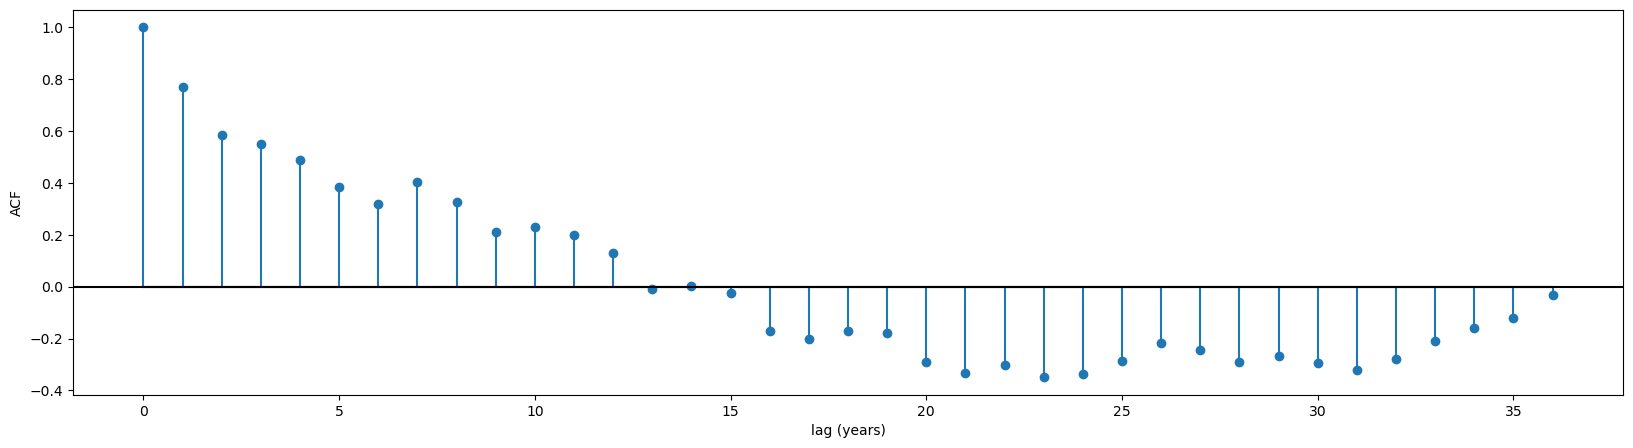

In [85]:
import scipy.stats 
import pymannkendall as mk
import pandas as pd

# load yearly global mean ERA5 + calculate anomalies
era_yearly = xr.open_dataset('../../data/era5_2m_temperature_1950-2021.gmean.yearly.nc').squeeze(['lat','lon'],drop=True)

era_clim_mean = era_yearly.t2m.sel(time=slice('1961','1990')).mean()
era_yearly['t2m_ano'] = (era_yearly.t2m-era_clim_mean)

# cut to same historical period as mentioned in the paper
# to have little trend in aerosol cooling + only weakly influnce on internal variability
era =  era_yearly.sel(time=slice('1981','2017'))

# check for autocorrelation
x = era.t2m_ano
y = x - x.mean('time')
acov = np.correlate(y, y, 'full')[len(x)-1:]
acorr = (acov / acov[0])

plt.close()
fig = plt.figure(figsize=(20,5))
plt.axhline(y=0, color='black')
plt.stem(np.arange(len(acorr)), acorr, basefmt='k-')
plt.xlabel('lag (years)')
plt.ylabel('ACF')
plt.show()

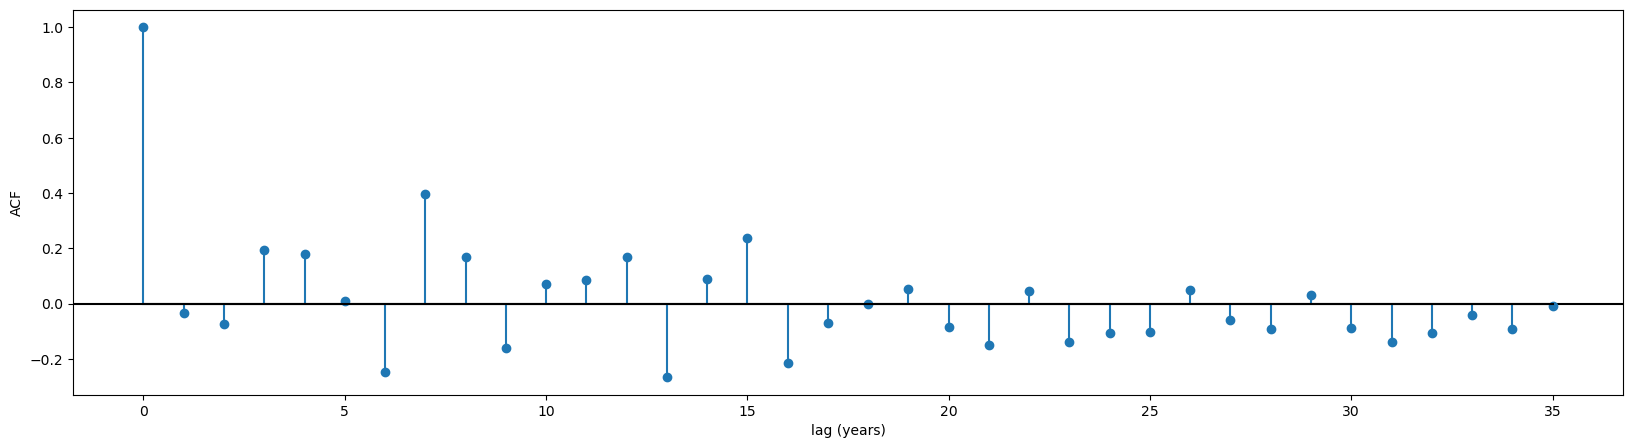

In [86]:
# remove autocorrelation
era_white = (era.t2m_ano.values[1:]-acorr[1]*era.t2m_ano.values[:-1])/(1-acorr[1])

x = era_white
y = x - x.mean()
acov = np.correlate(y, y, 'full')[len(x)-1:]
acorr = (acov / acov[0])

plt.close()
fig = plt.figure(figsize=(20,5))
plt.axhline(y=0, color='black')
plt.stem(np.arange(len(acorr)), acorr, basefmt='k-')
plt.xlabel('lag (years)')
plt.ylabel('ACF')
plt.show()

In [87]:
# Trend calculation after pre-whitening
lr_result = scipy.stats.linregress(
        np.arange(len(era.time)-1),
        era_white)
mk_result = mk.original_test(era_white)
mk2_result = mk.pre_whitening_modification_test(
        era.t2m_ano.values)

print(lr_result)
print(mk_result)
print(mk2_result)

LinregressResult(slope=0.02507815348605315, intercept=0.015164407280584158, rvalue=0.4515851100017068, pvalue=0.005698480241309106, stderr=0.008497523125606421, intercept_stderr=0.17293381666911697)
Mann_Kendall_Test(trend='increasing', h=True, p=0.01268031791827573, z=2.49262362617062, Tau=0.2920634920634921, s=184.0, var_s=5390.0, slope=0.024572325870394707, intercept=0.07230996619910002)
Modified_Mann_Kendall_Test_PreWhitening_Approach(trend='increasing', h=True, p=0.01268031791827573, z=2.49262362617062, Tau=0.2920634920634921, s=184.0, var_s=5390.0, slope=0.0192047119140625, intercept=0.04008789062500001)


Text(0.5, 1.0, 'ERA5 global air temperature relative to 1961-1990')

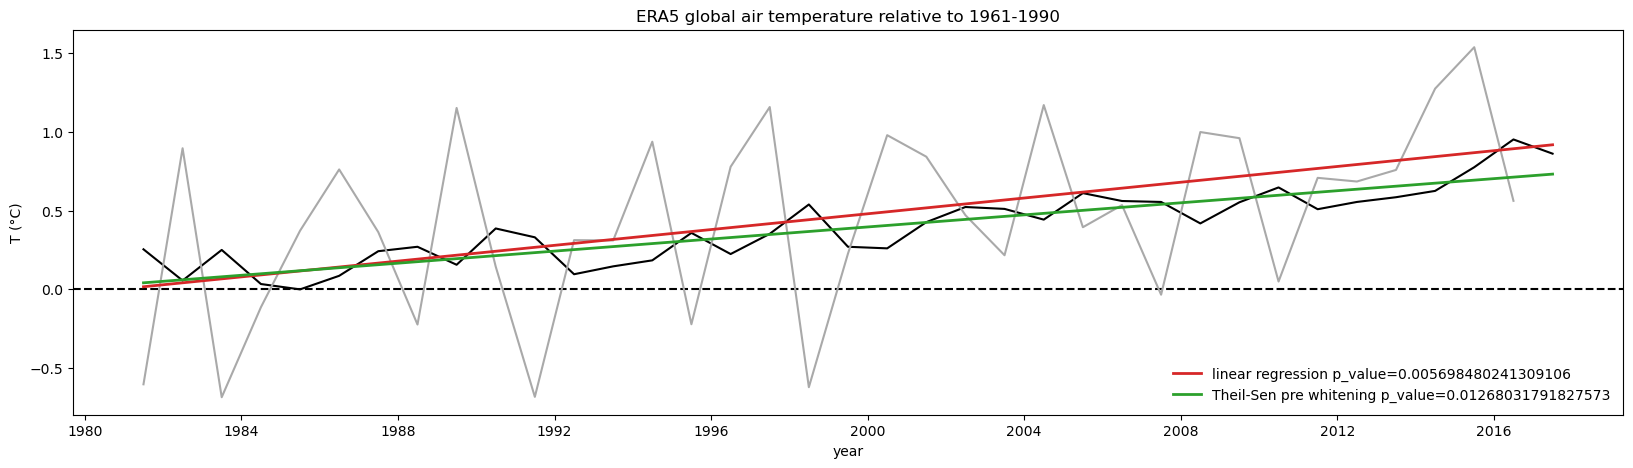

In [88]:
fig = plt.figure(figsize=(20,5))
plt.axhline(y=0.0, color='black', linestyle='--')
plt.plot(era.time, era.t2m_ano, color='black')[0]
plt.plot(era.time[:-1], era_white, color='darkgrey')[0]

h1 = plt.plot(era.time, lr_result.intercept + lr_result.slope*np.arange(len(era.time)), 
              color='tab:red', linewidth=2.0)[0]
#h2 = plt.plot(era.time, mk_result.intercept + mk_result.slope*np.arange(len(era.time)), 
#              color='tab:blue', linewidth=2.0)[0]
h3 = plt.plot(era.time, mk2_result.intercept + mk2_result.slope*np.arange(len(era.time)), 
              color='tab:green', linewidth=2.0)[0]

plt.xlabel('year')
plt.ylabel('T (°C)')

plt.legend([h1, h3], ['linear regression p_value='+str(lr_result.pvalue), 'Theil-Sen pre whitening p_value='+str(mk2_result.p)], loc='lower right', frameon=False)
plt.title('ERA5 global air temperature relative to 1961-1990')

The slope values don't differ that much with the Theil-Sen regression showing a slightly smaller trend then the linear regression (0.019 °C (Theil-Sen) and 0.025 °C (lin-reg)). The Theil-Sen regression matches the mid period of the timeseries better while the linear regression matches the ending better. Both regression methods show a p-values under 0.05 which means both regression trends are statistical significant. 

In [89]:
# load cmip6 models 
cmip6 = xr.open_dataset('/users/students/a1400416/MDA/data/cmip6_ssp585.processed.nc')
# calculate anamolies of the cmip6 models
cmip6['tas_ano'] = (cmip6.tas - cmip6.sel(year=slice(1961,1990)).tas.mean('year')) 

#select past window -> same as before
cmip6_past = cmip6.sel(year=slice(1981,2017))

In [90]:
# check for auto correlation
acorr_list = []
for model in cmip6_past.model:
    x = cmip6_past['tas_ano'].sel(model=model).values
    y = x - x.mean()
    acov = np.correlate(y, y, 'full')[len(x)-1:]
    acorr = (acov / acov[0])
    acorr_list.append(acorr[1])
    
#    plt.close()
#    fig = plt.figure(figsize=(20,5))
#    plt.axhline(y=0, color='black')
#    plt.stem(np.arange(len(acorr)), acorr, basefmt='k-')
#    plt.xlabel('lag (years)')
#    plt.ylabel('ACF')
#    plt.show()

In [91]:
acorr =  np.array(acorr_list)[:,np.newaxis]
data_white = (cmip6_past.tas_ano.values[:,1:]-acorr*cmip6_past.tas_ano.values[:,:-1])/(1-acorr)

In [92]:
# calculate autocorrelation for checking 
for i in range(len(data_white[:,0])):
    x = data_white[i,:]
    y = x - x.mean()
    acov = np.correlate(y, y, 'full')[len(x)-1:]
    acorr = (acov / acov[0])

#    plt.close()
#    fig = plt.figure(figsize=(20,5))
#    plt.axhline(y=0, color='black')
#    plt.stem(np.arange(len(acorr)), acorr, basefmt='k-')
#    plt.xlabel('lag (years)')
#    plt.ylabel('ACF')
#    plt.show()

In [93]:
# Trend calculation after pre-whitening

df = pd.DataFrame([[lr_result.slope,lr_result.pvalue]], index = ['ERA'], columns = ['slope','pvalue'])
for i, model in zip(range(len(data_white[:,0])), cmip6_past.model):
    name = str(model.values)
    reg= scipy.stats.linregress(
        np.arange(len(cmip6_past['year'])-1),
        data_white[i,:])
    df.loc[name] = [reg.slope, reg.pvalue]

In [94]:
df.where(df.pvalue > 0.05).dropna()

,slope,pvalue
ACCESS-ESM1-5,0.038542,0.058075
CMCC-CM2-SR5,0.037089,0.095611
CMCC-ESM2,0.017358,0.199581
EC-Earth3,0.047396,0.068583
EC-Earth3-CC,0.040478,0.053724
INM-CM4-8,0.022825,0.055403
MIROC6,0.014078,0.078157
NorESM2-LM,0.025210,0.091033
NorESM2-MM,0.030190,0.057664


Text(0, 0.5, 'pvalue')

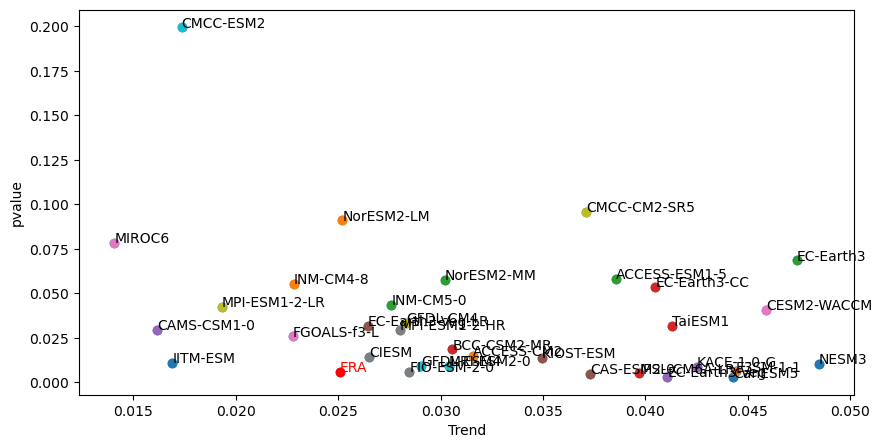

In [95]:
df_clean = df #df.where(df.pvalue < 0.05).dropna()
fig = plt.figure(figsize = (10,5))
plt.scatter(df_clean.slope,df_clean.pvalue)
for i, txt in enumerate(df_clean.index):
    if txt == 'ERA':
        plt.scatter(df_clean.slope[i],df_clean.pvalue[i], color = 'red')
        plt.annotate(txt, (df_clean.slope[i], df_clean.pvalue[i]),color = 'red')
    else: 
        plt.scatter(df_clean.slope[i],df_clean.pvalue[i])
        plt.annotate(txt, (df_clean.slope[i], df_clean.pvalue[i]))
plt.xlabel('Trend')
plt.ylabel('pvalue')

In [96]:
print('Minimum: ' , df.where(df.slope == df.slope.min()).dropna())
print('Maxmimum: ' , df.where(df.slope == df.slope.max()).dropna())
df['slope_diff_era'] = abs(df.slope - df.slope.ERA)
print('Nearest to ERA: ' , df.where(df.slope_diff_era == df.slope_diff_era[1:].min()).dropna())

Minimum:             slope    pvalue
MIROC6  0.014078  0.078157
Maxmimum:            slope   pvalue
NESM3  0.048465  0.01026
Nearest to ERA:                slope    pvalue  slope_diff_era
NorESM2-LM  0.02521  0.091033        0.000132


## 4) Establish an emergent relationship between past temperature trend and future warming

Calculate the warming trend between a past and a future period in the CMIP6 models. In each
case justify
your choice of the period, as a starting point you can use the same periods as in
the Figure 1. Why might it be good to change them? Visualize the relationship between the
two metrics including a statistical measure of their correlation. Interpret and discuss the result.
(Optional: vary the time periods and investigate how the correlation changes.)


In [110]:
def trend_vs_futurechange(cmip6,past_period, future_period):
    cmip_future = cmip6.sel(year=slice(int(future_period[0:4]),int(future_period[-4:])))
    cmip6_past = cmip6.sel(year=slice(int(past_period[0:4]),int(past_period[-4:])))
    
   # y = cmip6_past - cmip6_past.mean()
   # acov = np.correlate(y, y, 'full')[len(x)-1:]
   # acorr = (acov / acov[0])
    trend = cmip6_past.polyfit(dim = 'year',deg=1)
    trend = trend.sel(degree=1).polyfit_coefficients *10

    change_future = cmip_future.mean('year') - cmip6_past.mean('year')
    
    plt.close()
    fig = plt.figure(figsize=(5,5))
    plt.scatter(trend,change_future)
    plt.title('Correlation = %0.2f' %np.corrcoef(trend.values, change_future.values)[0,1])
    plt.xlabel('Temperature trend ' + past_period + ' (°C/decade)')
    plt.ylabel('SSP $\Delta$T ' + future_period + ' (°C)')
    plt.show()
    
    return trend, change_future

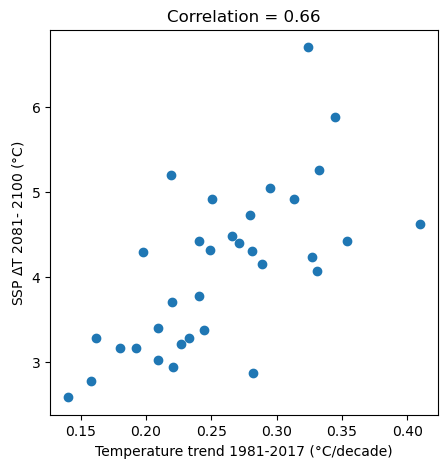

In [98]:
_ = trend_vs_futurechange(cmip6.tas_ano,'1981-2017','2081- 2100')

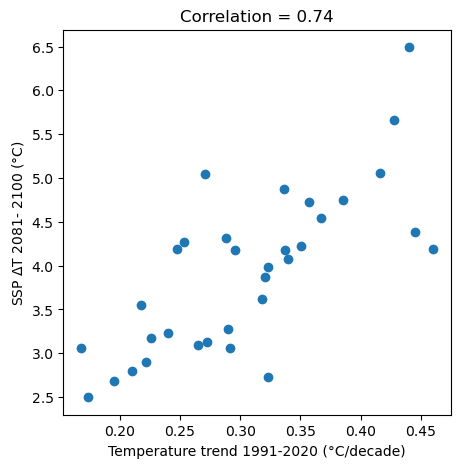

In [99]:
#extend to 2020 to get 30 year climate period
_ = trend_vs_futurechange(cmip6.tas_ano,'1991-2020','2081- 2100')

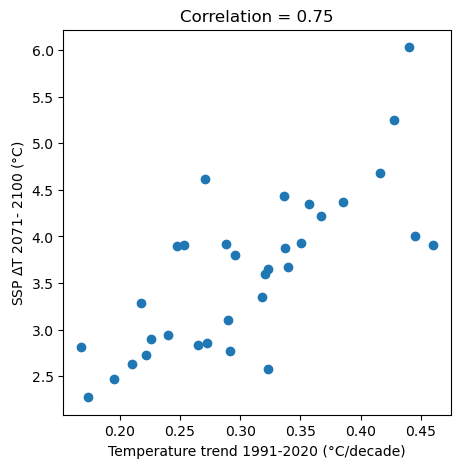

In [100]:
#future period 2071-2100 to get also there a 30 year climate period
trend, change_future = trend_vs_futurechange(cmip6.tas_ano,'1991-2020','2071- 2100')

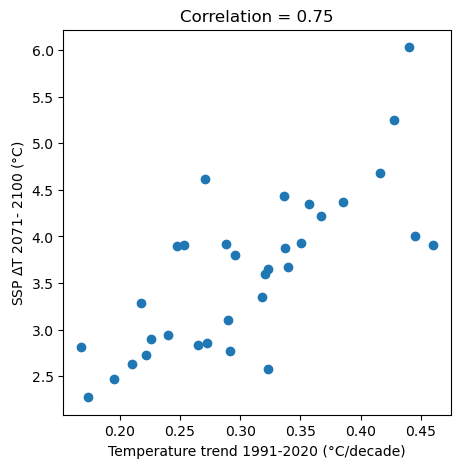

In [109]:
#future period 2071-2100 to get also there a 30 year climate period
trend, change_future = trend_vs_futurechange(cmip6.tas_ano,'1991-2020','2071- 2100')

# 5) Constrain future warming using the historical observations from ERA5
Next, use the global annual mean ERA5 data to constrain future warming. To do so first
constrain the historical trend by comparing the model trends to the trend from ERA5. To get
an estimate of trend uncertainty you can approximate the uncertainty from the Figure 1 (grey
shaded area) and re-use it here. (Optional: as an alternative, you can calculate multiple trend
values from a period in which we can assume there was hardly any warming and evaluate them
(you can do this either in ERA5 or one or more models)). How do your values compare to the
values shown in the figure?
To constrain future warming disregard models which are not consistent with observed warming
(i.e., models with trend values outside the uncertainty range of the ERA5 trend). Calculate
both, the constrained and unconstrained distributions of future warming (e.g., using the standard
deviation or a comparable metric) and compare them. Discuss the results, what was the potential
problems with this approach?

In [105]:
cmip6_df = pd.DataFrame(zip(trend.values,change_future.values),index = cmip6.model, columns = ['trend','change_future'])
cmip6_constraint = cmip6_df.where((cmip6_df.trend < 0.3) & (cmip6_df.trend > 0.2) ).dropna()
cmip6_removed = cmip6_df.drop(cmip6_constraint.index) 

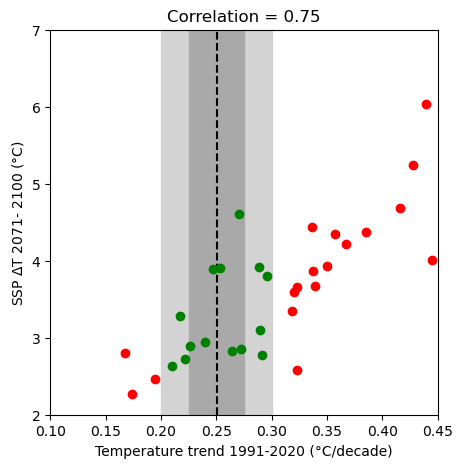

In [106]:
plt.close()
fig = plt.figure(figsize=(5,5))
plt.scatter(cmip6_constraint.trend,cmip6_constraint.change_future, color = 'green', zorder = 3)
plt.scatter(cmip6_removed.trend,cmip6_removed.change_future, color = 'red', zorder = 3)
plt.vlines(df.loc['ERA'].slope*10,ymin = 2, ymax = 7,color = 'k', linestyle = '--', zorder = 2)
plt.fill_between(np.linspace(0.2,0.3), 0, y2=7, color = 'lightgrey',zorder = 0)
plt.fill_between(np.linspace(0.225,0.275), 0, y2=7, color = 'darkgrey',zorder = 0)
plt.title('Correlation = %0.2f' %np.corrcoef(trend.values, change_future.values)[0,1])
plt.xlabel('Temperature trend 1991-2020 (°C/decade)')
plt.ylabel('SSP $\Delta$T 2071- 2100 (°C)')
plt.xlim(0.1,0.45)
plt.ylim(2,7)
plt.show()

In comparison to the figure in the paper, the temperature trend of ERA5 in the past is 0.5°C/decade higher which leads to the exclusion of some climate models which show a smaller trend in the past than ERA5 (< 0.2°C/decade).
In comparison the correlation between temperature trend in the past and future warming isn't as high as the one in the paper ( 0.75 compared to 0.86) which may be caused by the inclusion of trends which show no statisical significance. 

In [107]:
cmip6_df.describe()

,trend,change_future
count,33.000000,33.000000
mean,0.305265,3.624990
std,0.079316,0.854719
min,0.167875,2.273802
25%,0.247317,2.857671
50%,0.296061,3.674931
75%,0.350278,4.008861
max,0.460277,6.030821


In [108]:
cmip6_constraint.describe()

,trend,change_future
count,14.000000,14.000000
mean,0.256473,3.298777
std,0.029785,0.612367
min,0.210377,2.629515
25%,0.229717,2.839924
50%,0.259212,3.023247
75%,0.284474,3.872159
max,0.296061,4.612087


(<AxesSubplot:>, <AxesSubplot:>)

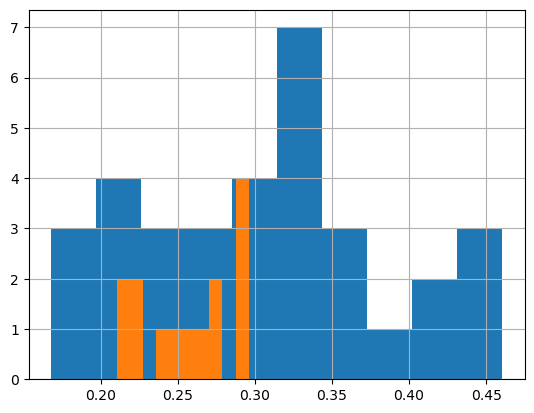

In [113]:
cmip6_df.trend.hist(), cmip6_constraint.trend.hist()

Constraining the data with ERA5 leads to a reduction in the mean future warming (from 3.62 to 3.30 °C) but also to a strong reduction in the uncertainty (0.61°C standard diviation constrainted in comparison to 0.85°C). <br>
The approach is very sensitive to the periods choosen for the calculation but also for the respective regression method used which might lead to exclusion of some models which would be included with other methods.
